/anaconda3/lib/python3.7/site-packages/matplotlib/figure.py:2299: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


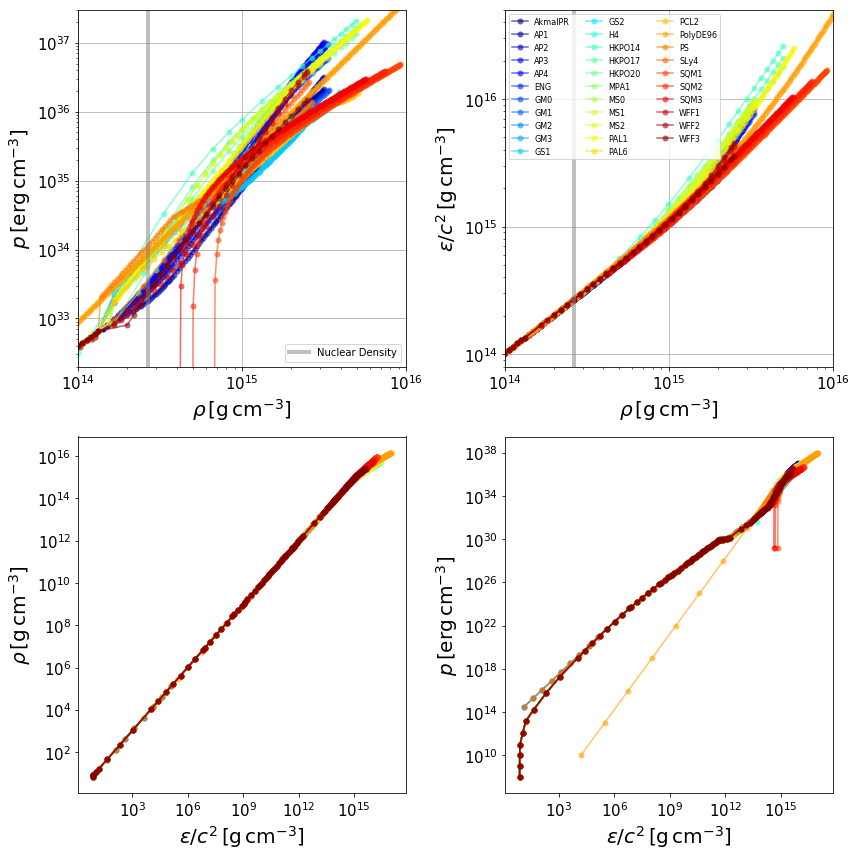

In [2]:
import numpy as np
from numpy import log10 as lg
from scipy.interpolate import interp1d as sp_interp1d
import matplotlib.pyplot as plt
import matplotlib
from matplotlib import cm

C = 29979245800.0  # cm/s

matplotlib.rc('xtick', labelsize=15)
matplotlib.rc('ytick', labelsize=15)
matplotlib.rc('lines', markeredgewidth=0)

EOS_NAMES = ['AkmalPR', 'AP1', 'AP2', 'AP3', 'AP4', 'ENG',
    'GM0', 'GM1', 'GM2', 'GM3', 'GS1', 'GS2', 'H4', 'HKPO14',
    'HKPO17', 'HKPO20', 'MPA1', 'MS0', 'MS1', 'MS2', 'PAL1',
    'PAL6', 'PCL2', 'PolyDE96', 'PS', 'SLy4', 'SQM1', 'SQM2', 'SQM3',
    'WFF1', 'WFF2', 'WFF3']

class EOS(object):
    """ Provide conversions between n, p, e, rho, with linear interpolations
        in logspace from tabulated values.

        All quantities are in cgs unit.
    """

    def __init__(self, name='AP4'):
        """ Initialize EOS instance with interp1d from scipy.interpolate
        """
        if not name in EOS_NAMES:
            print(' <<< EOS %s not found >>> ' % name)

        self.name = name
        self.mB = 1.660538921e-24  # g

        dat = np.genfromtxt('code/EOS/' +
                            name + '.txt')
        self.rho, self.p, self.e = dat[:, 0], dat[:, 1], dat[:, 2]
        self.min_rho = np.min(self.rho)
        self.max_rho = np.max(self.rho)
        self.min_p = np.min(self.p)
        self.max_p = np.max(self.p)
        self.min_e = np.min(self.e)
        self.max_e = np.max(self.e)
        self.min_n = self.rho2n(self.min_rho)
        self.max_n = self.rho2n(self.max_rho)

        lgrho, lgp, lge = lg(self.rho), lg(self.p), lg(self.e)
        self.lgrho2lgp = sp_interp1d(lgrho, lgp)
        self.lgrho2lge = sp_interp1d(lgrho, lge)
        self.lgp2lgrho = sp_interp1d(lgp, lgrho)
        self.lgp2lge = sp_interp1d(lgp, lge)
        self.lge2lgp = sp_interp1d(lge, lgp)
        self.lge2lgrho = sp_interp1d(lge, lgrho)

    def __str__(self):
        """ Print EOS name """
        return (' <<< EOS name: %s >>> ' % self.name)

    def rho2p(self, rho):
        return 10.0**self.lgrho2lgp(lg(rho))

    def rho2n(self, rho):
        return rho / self.mB

    def rho2e(self, rho):
        return 10.0**self.lgrho2lge(lg(rho))

    def p2rho(self, p):
        return 10.0**self.lgp2lgrho(lg(p))

    def p2n(self, p):
        return self.p2rho(p) / self.mB

    def p2e(self, p):
        if p < self.min_p:
            return 1.0e-9
        return 10.0**self.lgp2lge(lg(p))

    def n2rho(self, n):
        return n * self.mB

    def n2p(self, n):
        return self.rho2p(n * self.mB)

    def n2e(self, n):
        return self.rho2e(n * self.mB)

    def e2p(self, e):
        if e < self.min_e:
            return 1.0e-9
        return 10.0**self.lge2lgp(lg(e))

    def e2n(self, e):
        return self.e2rho(e) / self.mB

    def e2rho(self, e):
        if e < self.min_e:
            return 1.0e-9
        return 10.0**self.lge2lgrho(lg(e))

    def plot(self):
        """ Plot p & e versus rho """
        plt.close('all')
        plt.figure(figsize=(12,6))
        plt.subplot(121)
        plt.loglog(self.rho, self.p, 'co', alpha=0.7)
        plt.xlabel(r'$\rho\,[{\rm g\,cm}^{-3}]$', fontsize=20)
        plt.ylabel(r'$p\,[{\rm erg\,cm}^{-3}]$', fontsize=20)
        plt.grid()
        plt.subplot(122)
        plt.loglog(self.rho, self.e, 'co', alpha=0.7)
        plt.xlabel(r'$\rho\,[{\rm g\,cm}^{-3}]$', fontsize=20)
        plt.ylabel(r'$\epsilon/c^2\,[{\rm g\,cm}^{-3}]$', fontsize=20)
        plt.grid()
        plt.gcf().set_tight_layout(True)
        plt.savefig(self.name + '.pdf')

if __name__ == '__main__':
    """ Plot all data points on one figure """
    n_nucl = 1.6e38
    plt.close('all')
    fig = plt.figure(figsize=(12,12))
    ax1 = fig.add_subplot(221)
    ax2 = fig.add_subplot(222)
    ax3 = fig.add_subplot(223)
    ax4 = fig.add_subplot(224)
    colors = cm.jet(np.linspace(0, 1, len(EOS_NAMES)))
    for i, eos_name in enumerate(EOS_NAMES):
        x = EOS(eos_name)
        ax1.loglog(x.rho, x.p, marker='o', alpha=0.6, color=colors[i])
        ax2.loglog(x.rho, x.e, marker='o', alpha=0.6, color=colors[i],
            label=eos_name)
        ax3.loglog(x.e, x.rho, marker='o', alpha=0.6, color=colors[i])
        ax4.loglog(x.e, x.p, marker='o', alpha=0.6, color=colors[i])
    ax1.axvline(x.n2rho(n_nucl), color='gray', linestyle='-', linewidth=4.,
            label='Nuclear Density', alpha=0.5)
    ax2.axvline(x.n2rho(n_nucl), color='gray', linestyle='-', linewidth=4.,
            alpha=.5)
    ax1.set_xlabel(r'$\rho\,[{\rm g\,cm}^{-3}]$', fontsize=20)
    ax1.set_ylabel(r'$p\,[{\rm erg\,cm}^{-3}]$', fontsize=20)
    ax2.set_xlabel(r'$\rho\,[{\rm g\,cm}^{-3}]$', fontsize=20)
    ax2.set_ylabel(r'$\epsilon/c^2\,[{\rm g\,cm}^{-3}]$', fontsize=20)
    ax3.set_xlabel(r'$\epsilon/c^2\,[{\rm g\,cm}^{-3}]$', fontsize=20)
    ax3.set_ylabel(r'$\rho\,[{\rm g\,cm}^{-3}]$', fontsize=20)
    ax4.set_xlabel(r'$\epsilon/c^2\,[{\rm g\,cm}^{-3}]$', fontsize=20)
    ax4.set_ylabel(r'$p\,[{\rm erg\,cm}^{-3}]$', fontsize=20)
    ax1.grid()
    ax2.grid()
    ax1.set_xlim((1e14, 1e16))
    ax1.set_ylim((2e32, 3e37))
    ax2.set_xlim((1e14, 1e16))
    ax2.set_ylim((8e13, 5e16))
    ax1.legend(loc='best')
    ax2.legend(loc='best', ncol=3, fontsize=8)
    plt.gcf().set_tight_layout(True)
    plt.savefig('fig_EOS.pdf')